<a href="https://colab.research.google.com/github/acucenarodrigues1998/Generative-AI/blob/main/01.DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Deep Convolutional GANs

## Importação das libs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.9.2'

## Carregamento e pré-processamento da base de dados

In [ ]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
X_treinamento.shape

(60000, 28, 28)

In [ ]:
28 * 28

784

In [ ]:
y_treinamento.shape

(60000,)

7


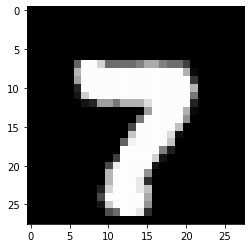

In [ ]:
i = np.random.randint(0, 60000)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

In [ ]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_treinamento.shape

(60000, 28, 28, 1)

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [ ]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
type(X_treinamento)

numpy.ndarray

In [ ]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [ ]:
def cria_gerador():

  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

In [ ]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
# 100 -> 12544
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
ruido = tf.random.normal([1,100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.3231527 , -0.24282692, -0.9586867 , -0.700549  ,  0.34931394,
         1.0719199 , -0.3817076 , -0.8679341 , -1.6003714 , -0.27023342,
        -0.630756  ,  0.22014923, -1.6654713 , -0.93575156,  1.4366528 ,
         0.7883698 ,  0.49615952, -0.94672537, -0.39247185,  0.8256063 ,
        -0.6997586 , -0.67490435, -1.3327935 , -0.14347239,  0.38885733,
        -0.73868495, -0.06504635,  0.9453122 ,  0.5639901 ,  0.46741772,
         0.84518176,  0.34087107, -1.1536151 , -0.82066214, -0.46129397,
         0.06403126,  0.7066775 , -0.28109258,  0.9431687 , -0.18770483,
        -0.5627358 ,  1.5570669 , -0.02855952,  1.3657191 ,  0.27164108,
        -0.6081381 ,  1.1394122 ,  0.0479692 , -0.51883966, -0.23383346,
         2.3234265 , -0.14230436, -0.9805293 , -1.9021906 , -0.54758024,
        -0.3221664 , -0.8843513 ,  1.1500479 , -0.26279104, -0.01344818,
        -0.18176638, -1.3580228 , -0.7505576 , -0.53365535,  1.0899277 ,
 

In [ ]:
imagem_gerada = gerador(ruido, training = False)

In [ ]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

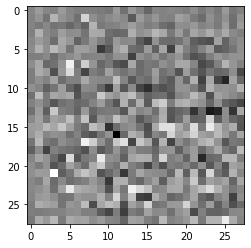

In [ ]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

## Construção do discriminador

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [ ]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size=(5,5), padding='same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size=(5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
discriminador(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00030241]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00132049)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49966988>

## Cálculo do Erro

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações. Ele compara as previsões do discriminador em imagens reais com uma matriz de 1s e as previsões do discriminador em imagens falsas (geradas) com uma matriz de 0s.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
tf.zeros_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [ ]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Treinamento da GAN e visualização dos resultados

- Adaptado de: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.

In [ ]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [ ]:
batch_size, dimensao_ruido

(256, 100)

In [ ]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     imagens_geradas = gerador(ruido, training = True)

     expected_output = discriminador(imagens, training = True)
     fake_output = discriminador(imagens_geradas, training = True)

     gen_loss = gerador_loss(fake_output)
     disc_loss = discriminador_loss(expected_output, fake_output)
  
  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [ ]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [ ]:
60000 / 256

234.375

In [ ]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize = (10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Época:  1


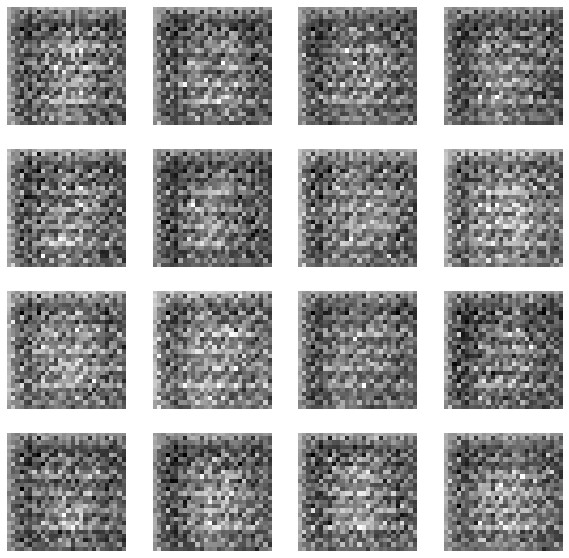

Época:  2


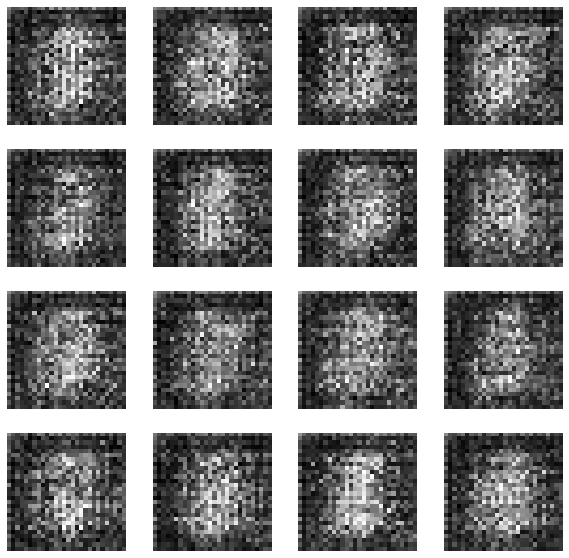

Época:  3


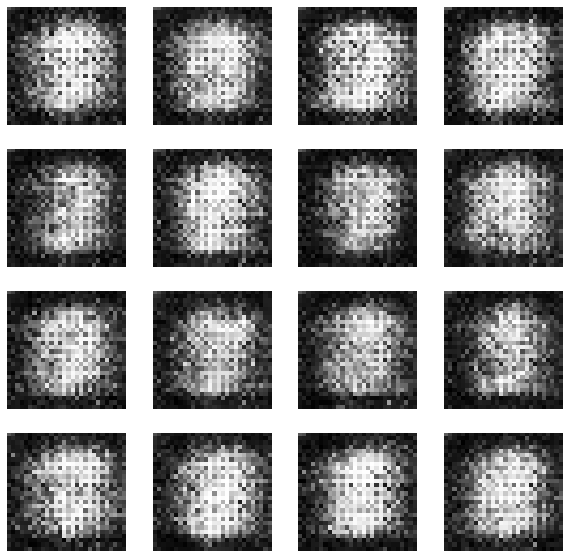

Época:  4


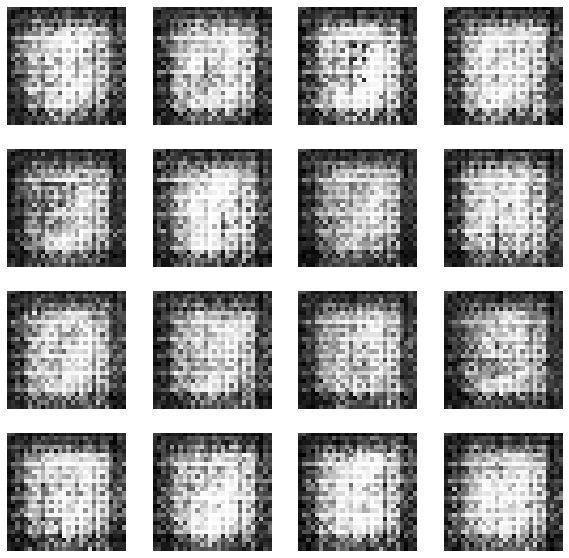

Época:  5


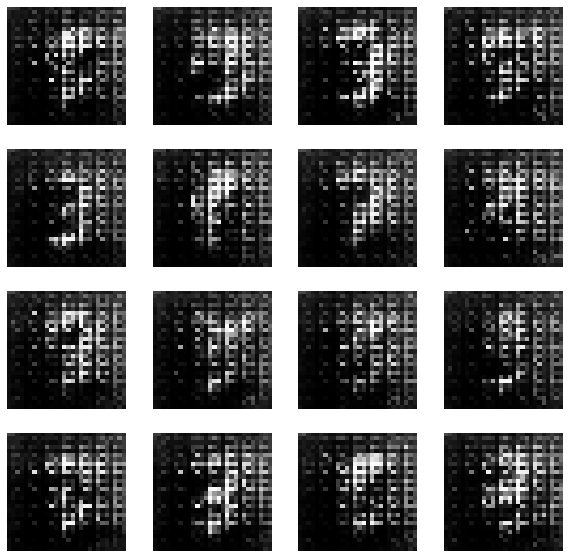

Época:  6


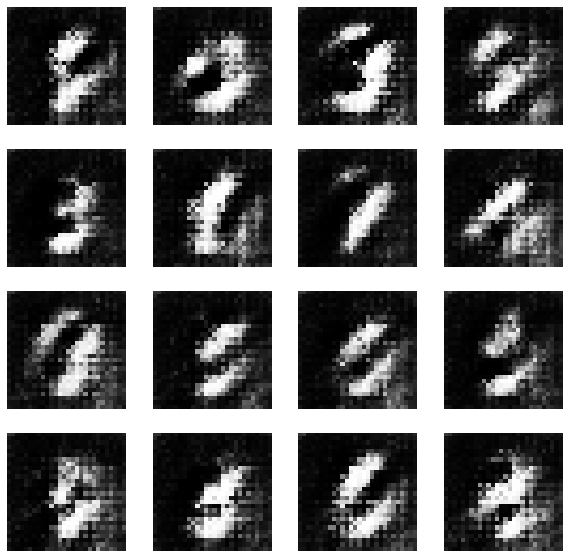

Época:  7


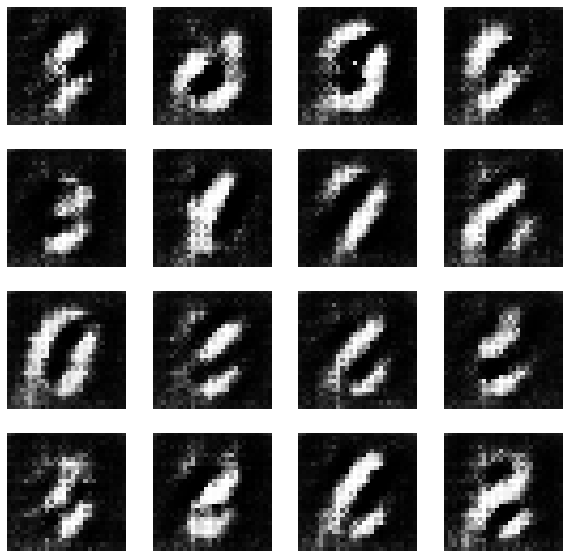

Época:  8


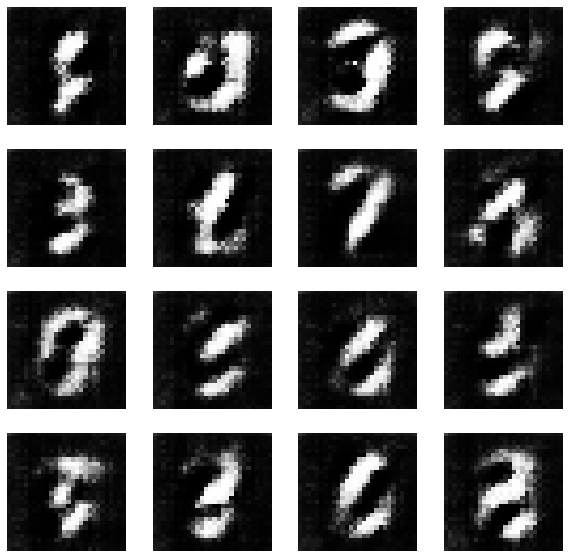

Época:  9


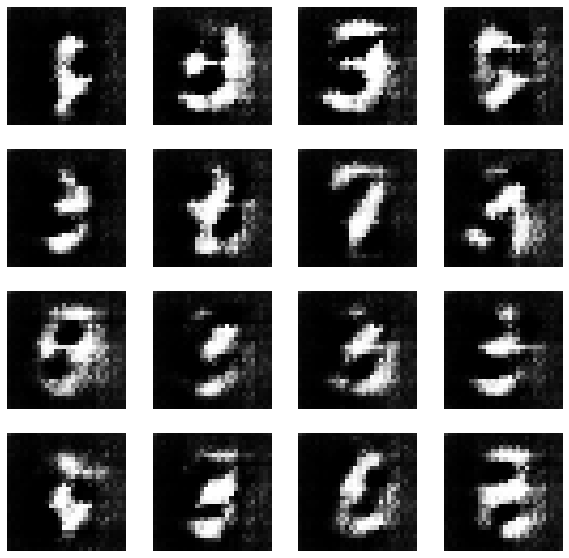

Época:  10


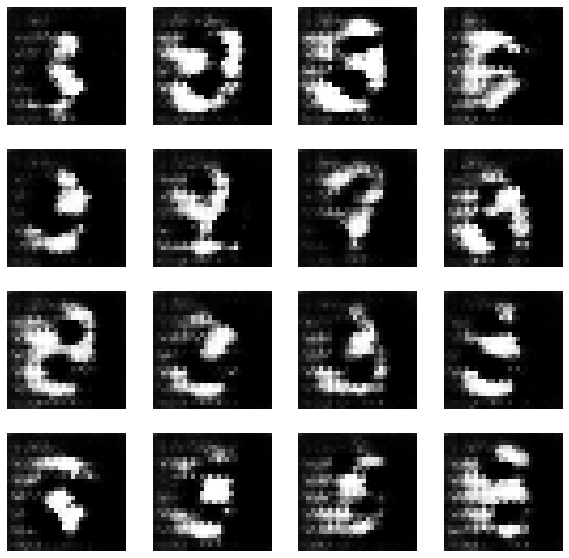

Época:  11


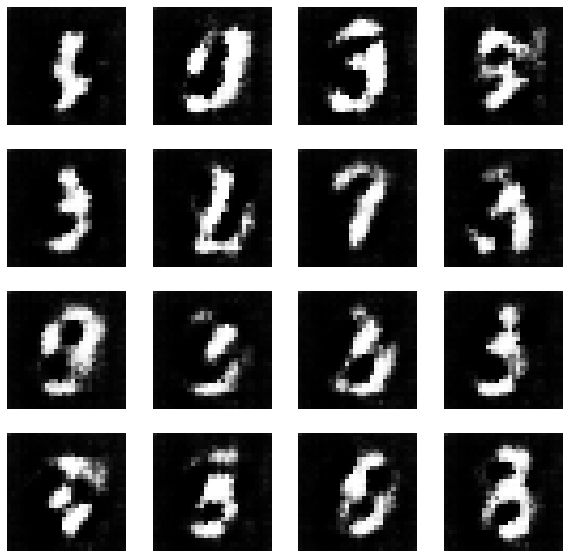

Época:  12


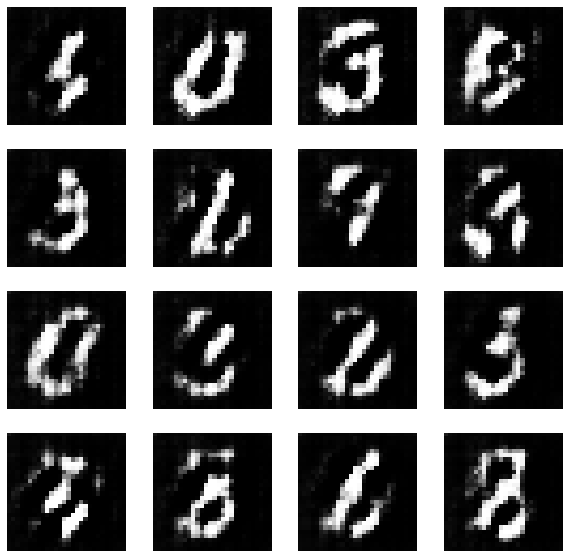

Época:  13


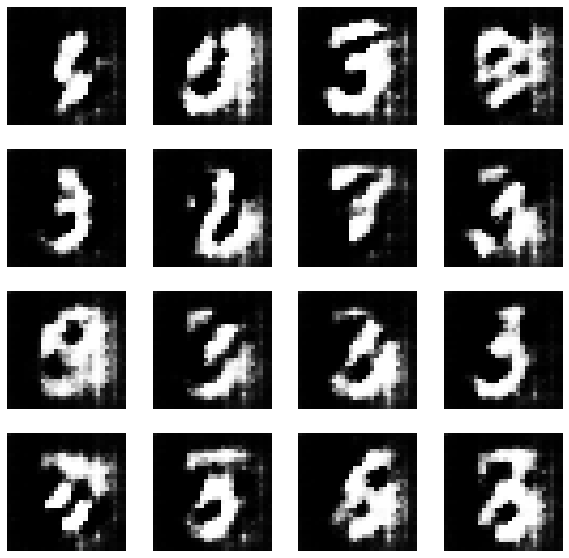

Época:  14


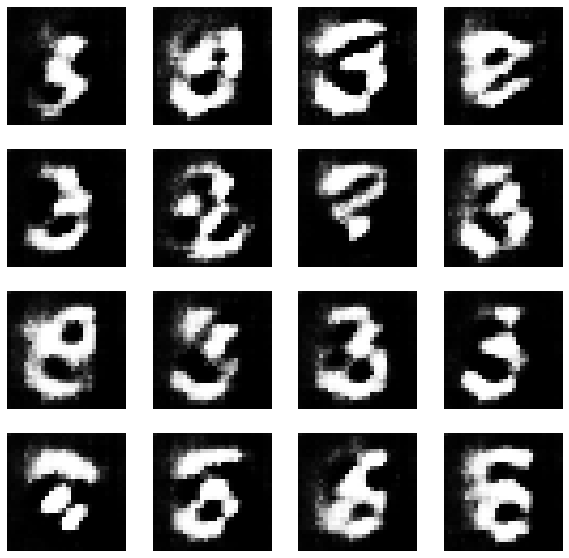

Época:  15


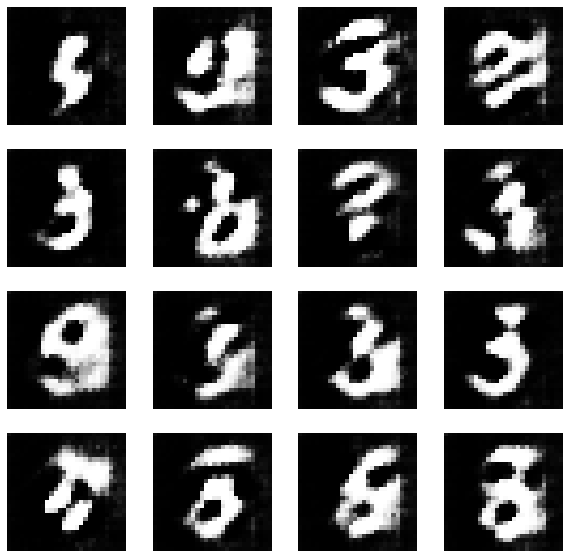

Época:  16


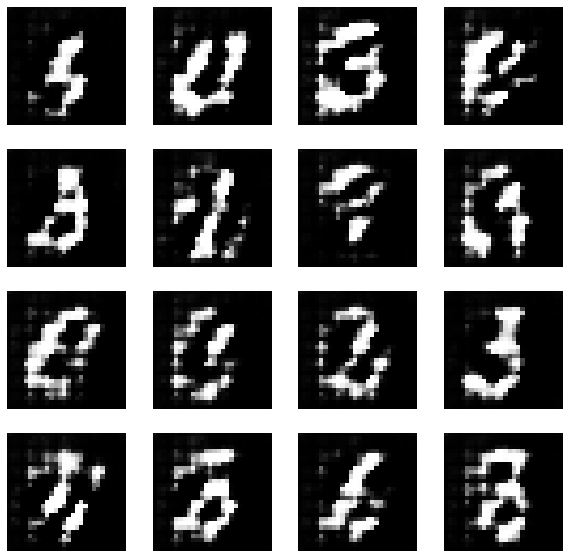

Época:  17


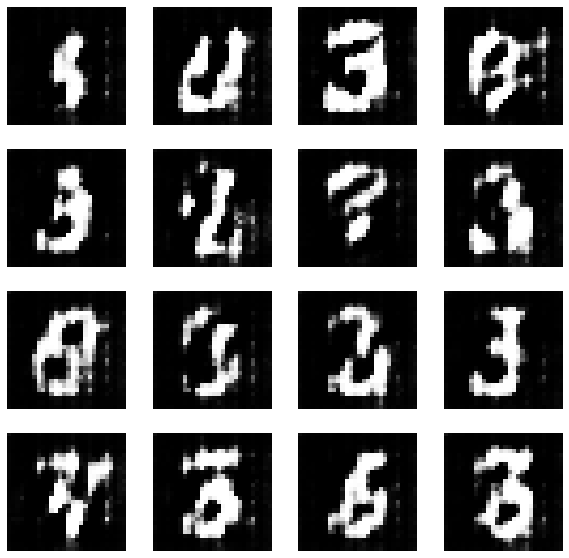

Época:  18


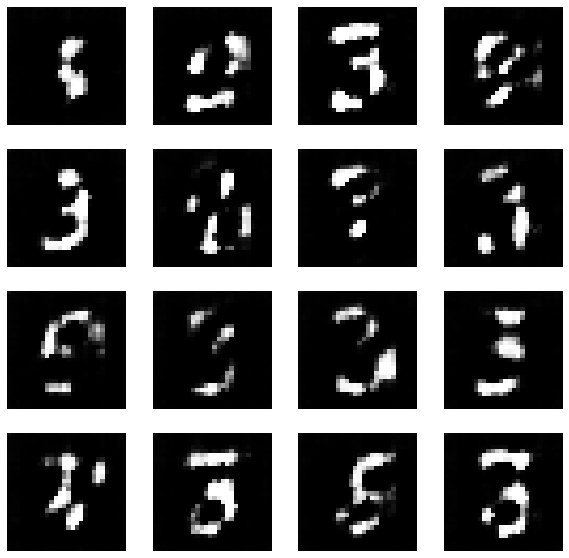

Época:  19


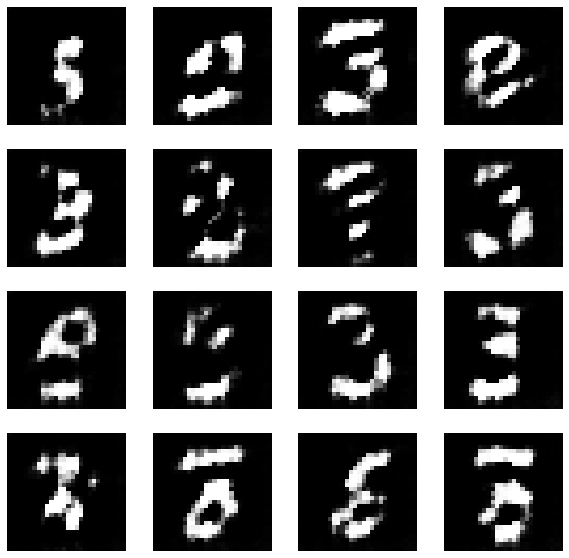

Época:  20


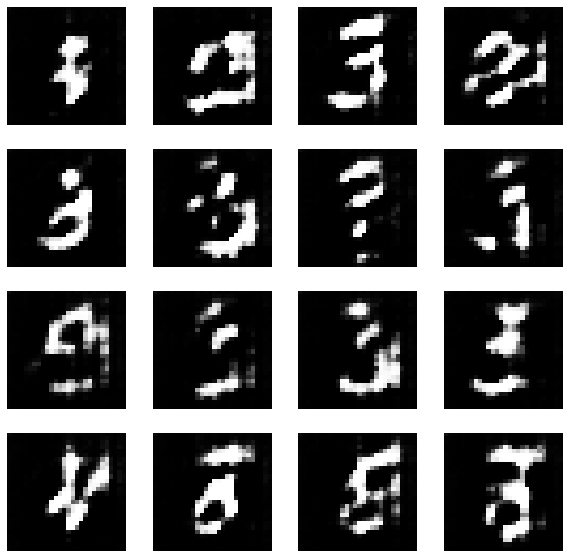

Época:  21


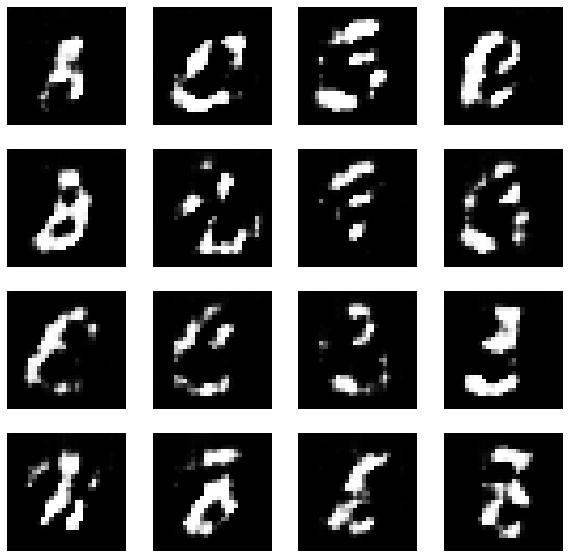

Época:  22


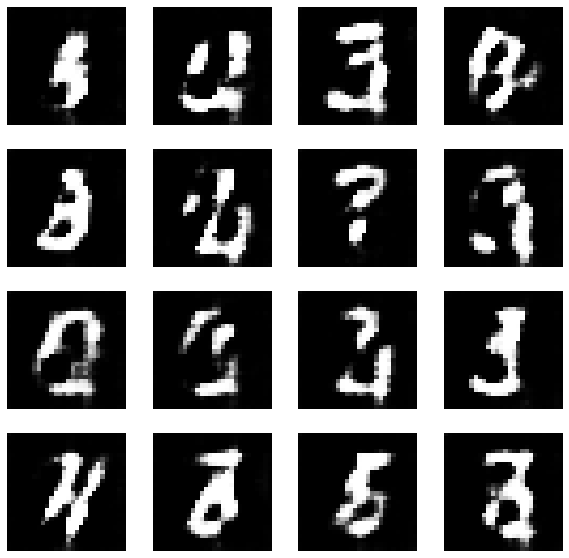

Época:  23


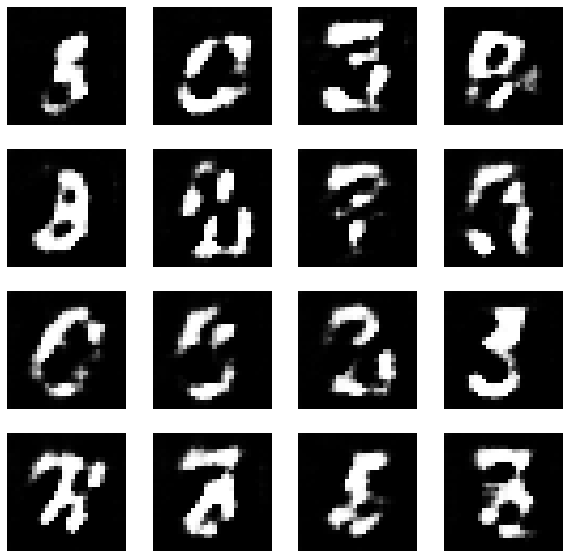

Época:  24


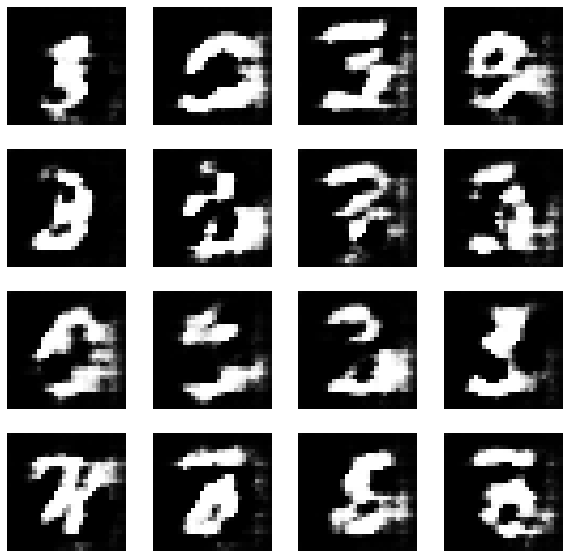

Época:  25


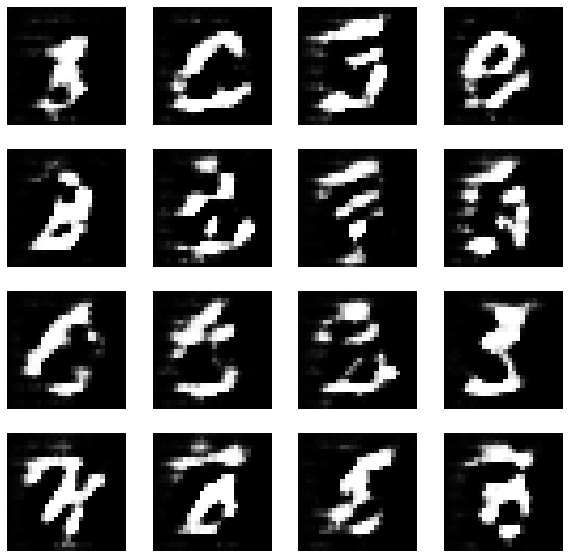

Época:  26


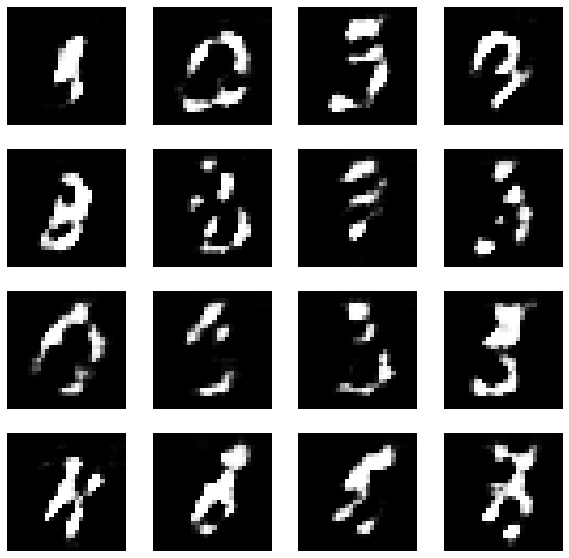

Época:  27


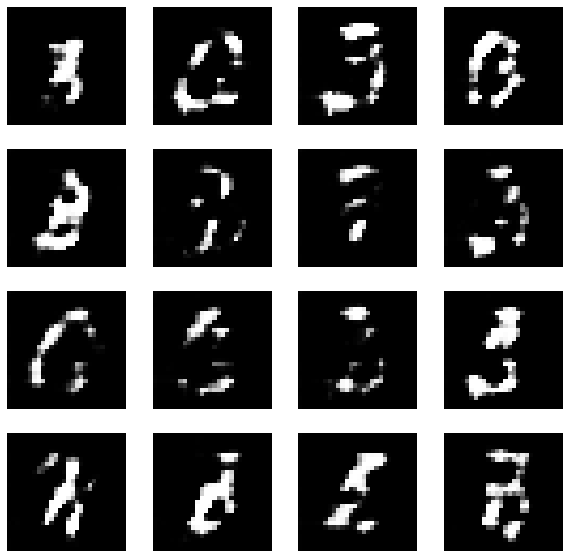

Época:  28


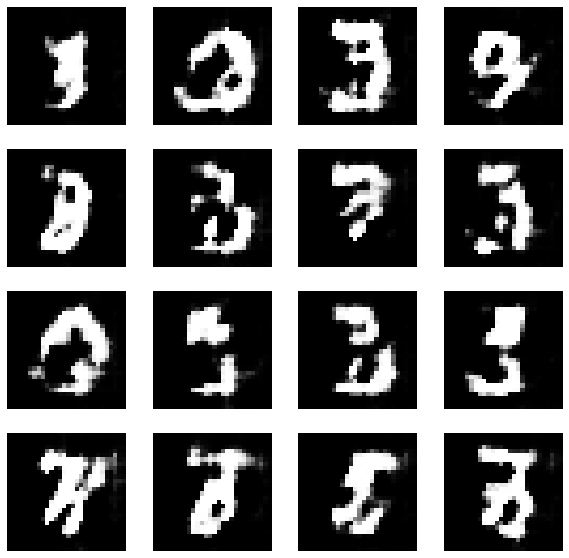

Época:  29


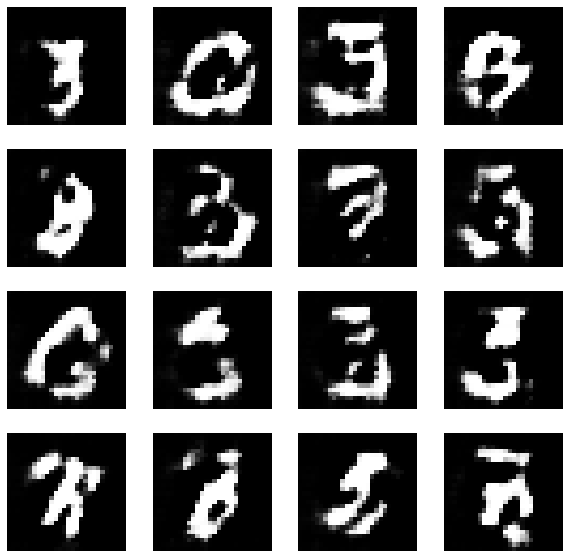

Época:  30


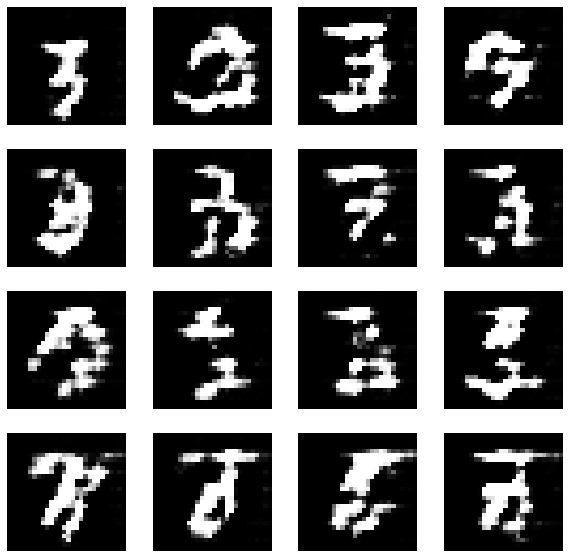

Época:  31


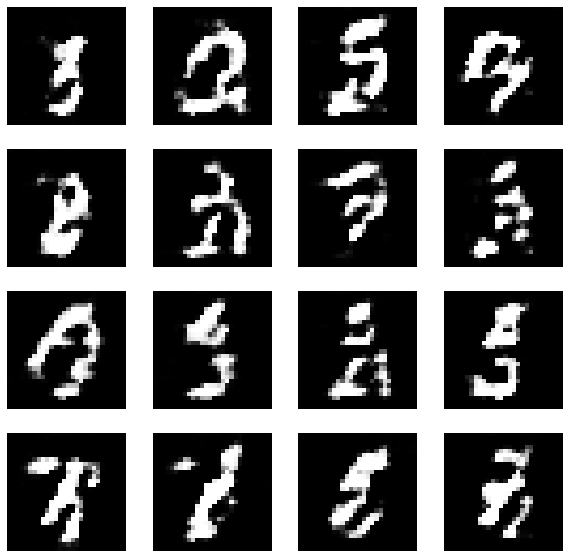

Época:  32


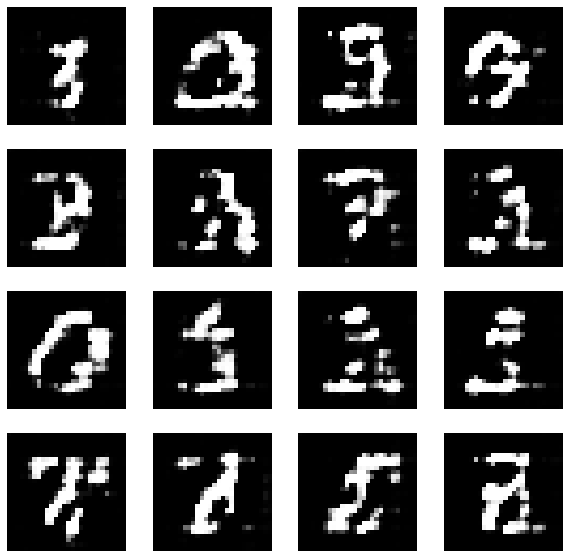

Época:  33


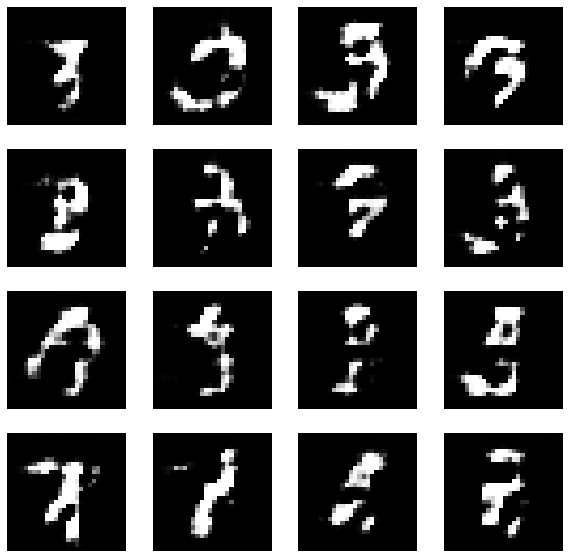

Época:  34


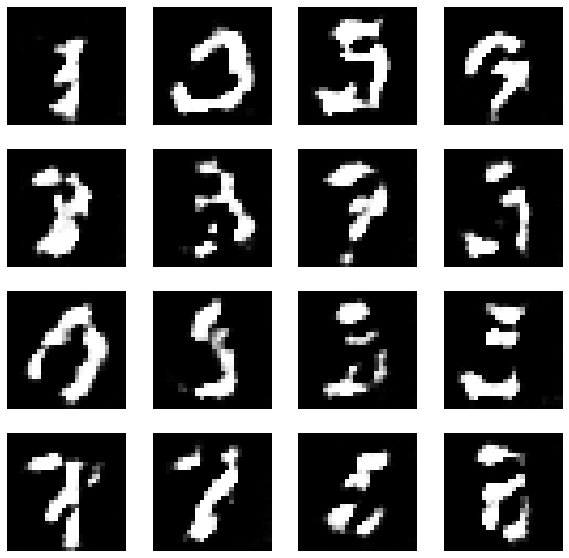

Época:  35


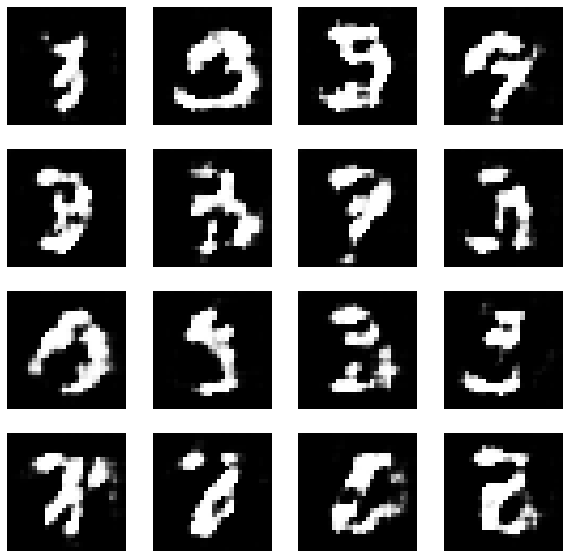

Época:  36


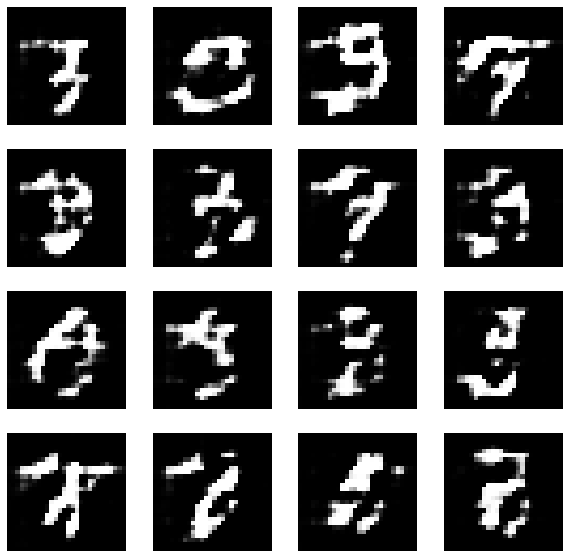

Época:  37


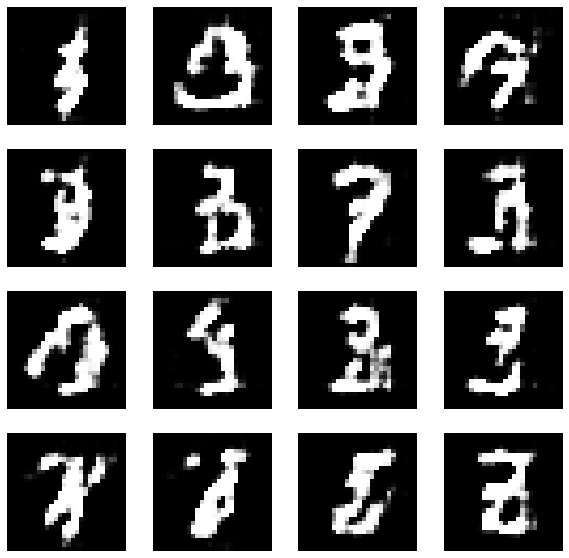

Época:  38


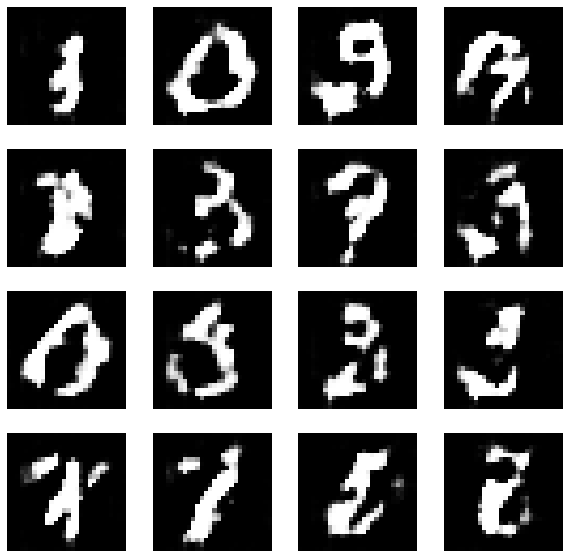

Época:  39


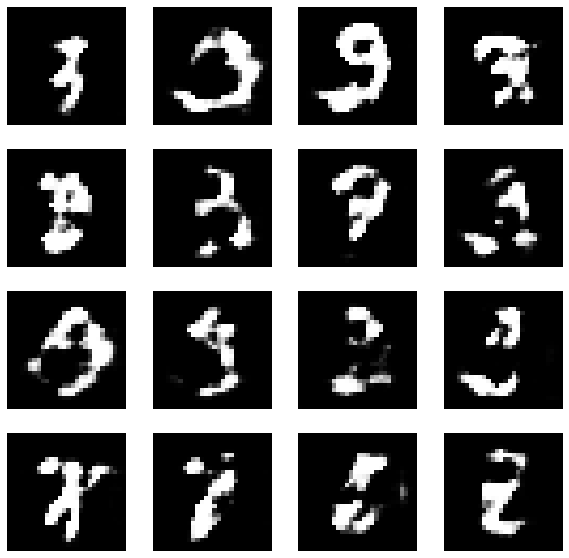

Época:  40


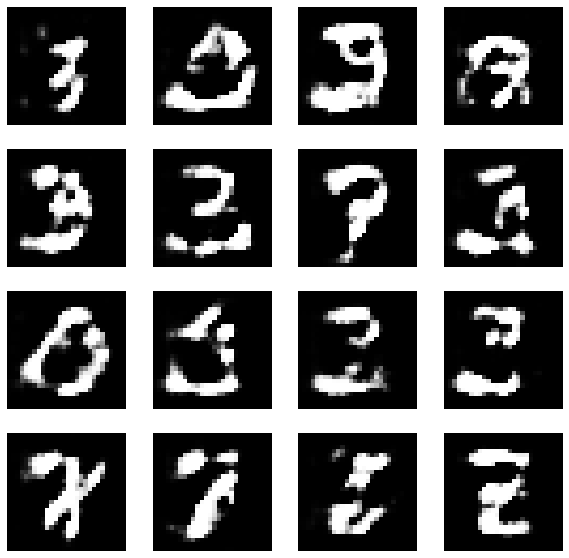

Época:  41


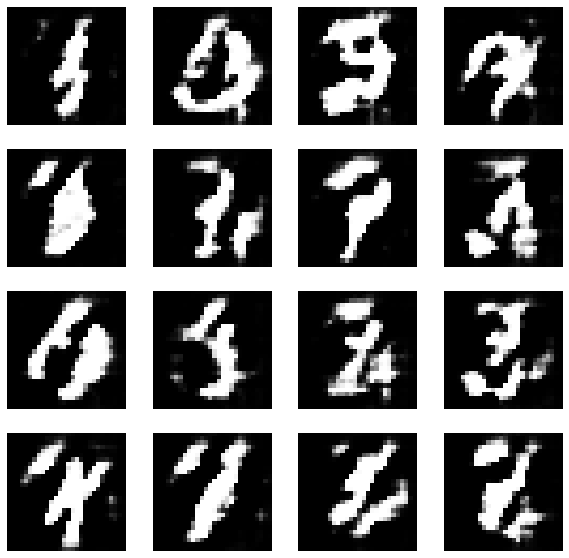

Época:  42


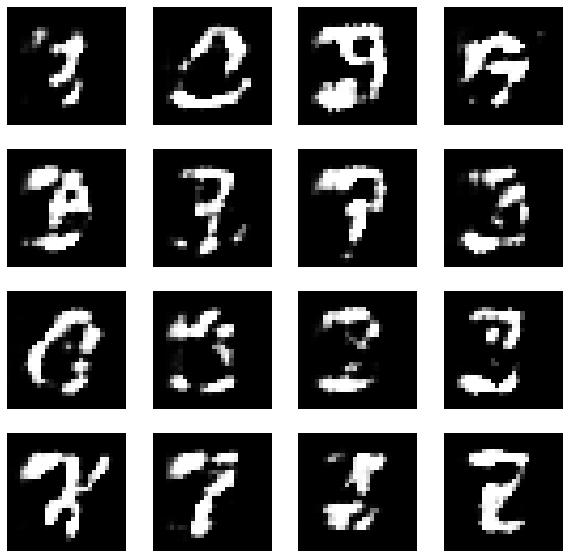

Época:  43


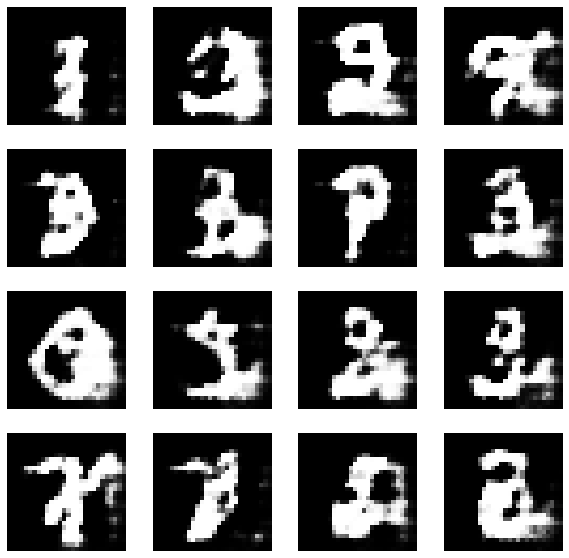

Época:  44


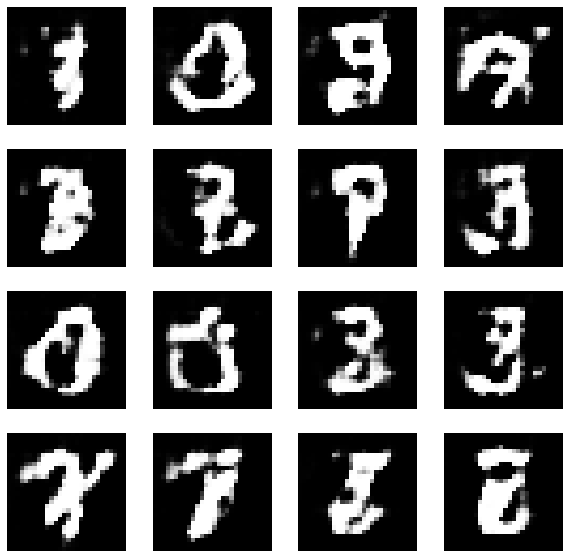

Época:  45


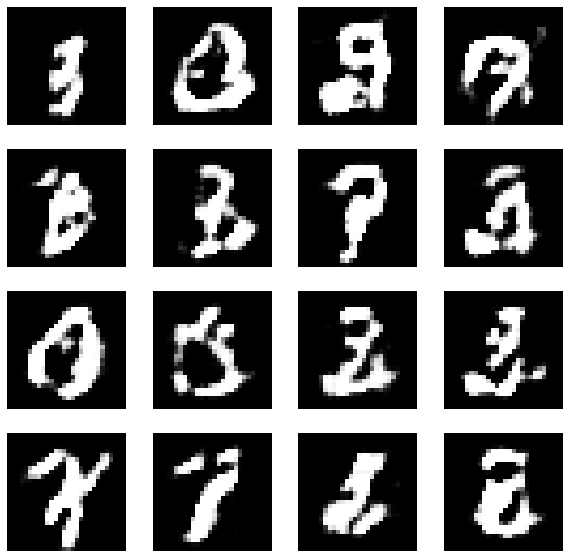

Época:  46


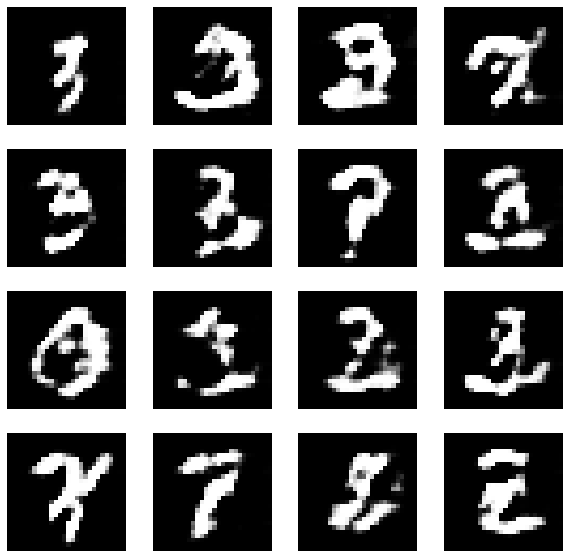

Época:  47


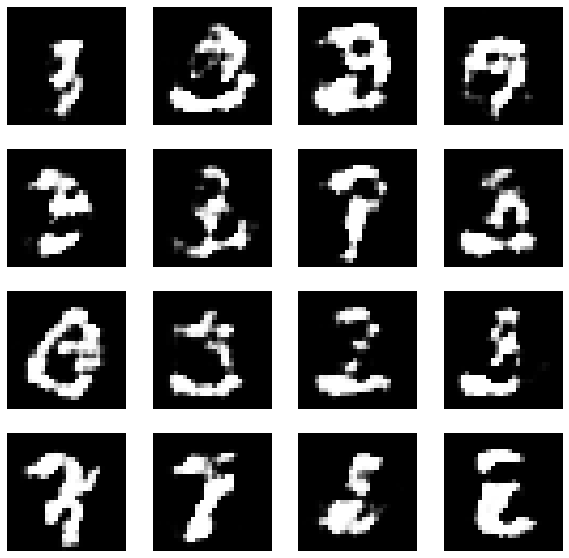

Época:  48


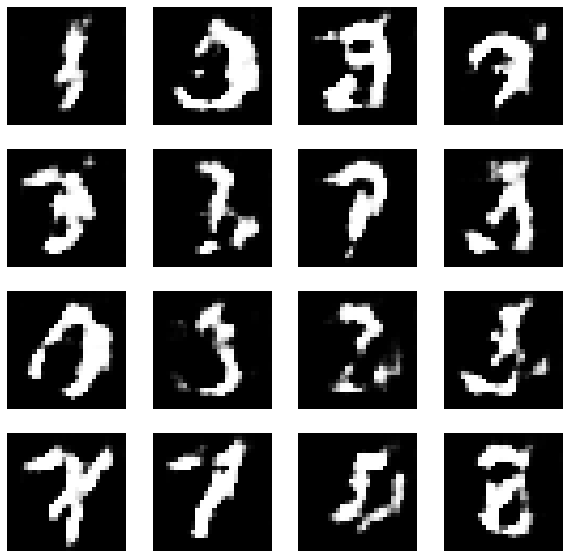

Época:  49


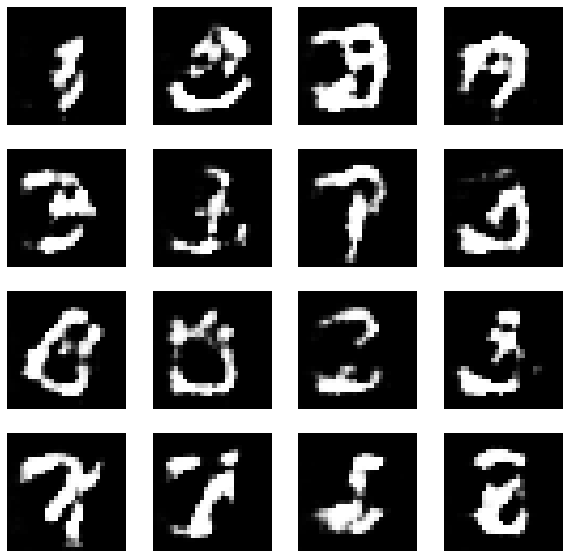

Época:  50


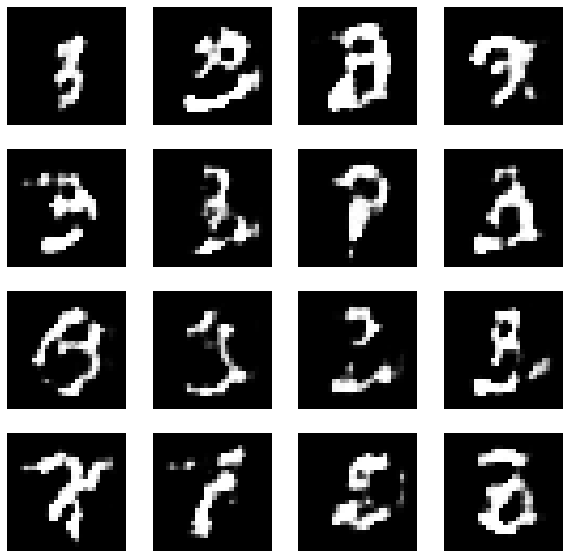

Época:  51


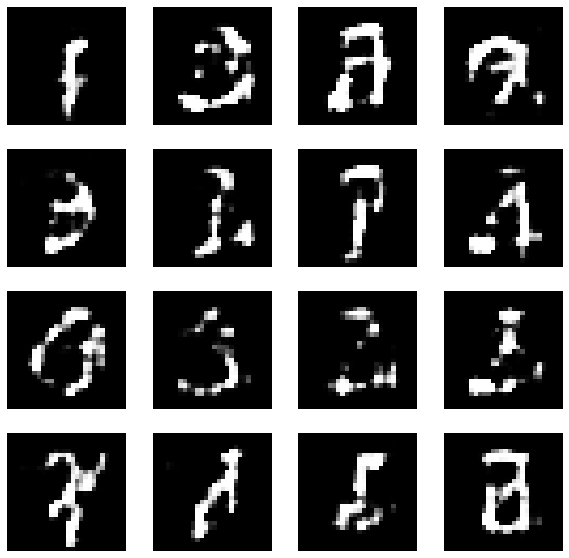

Época:  52


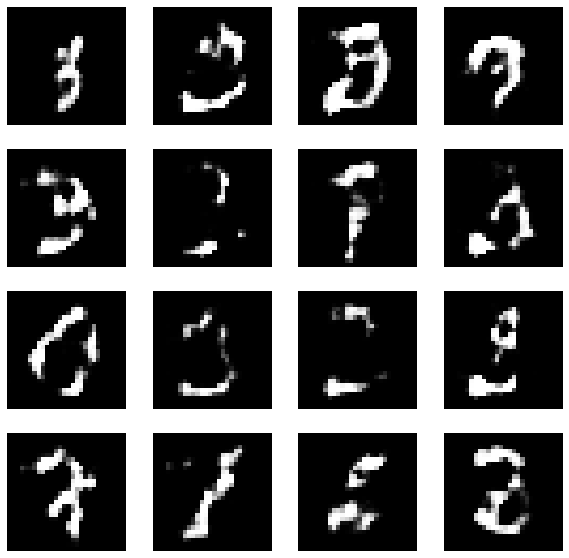

Época:  53


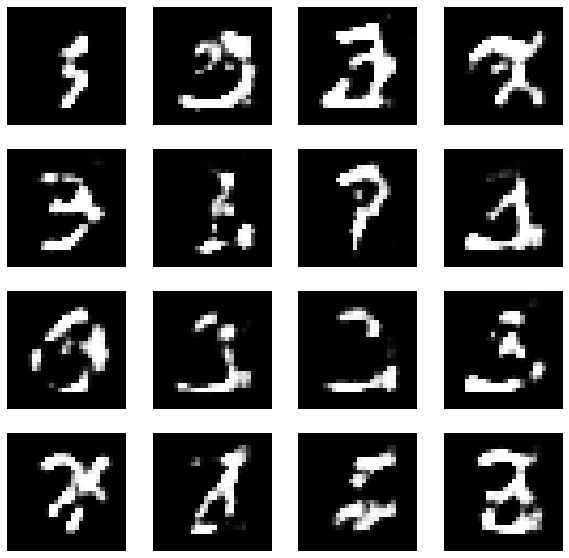

Época:  54


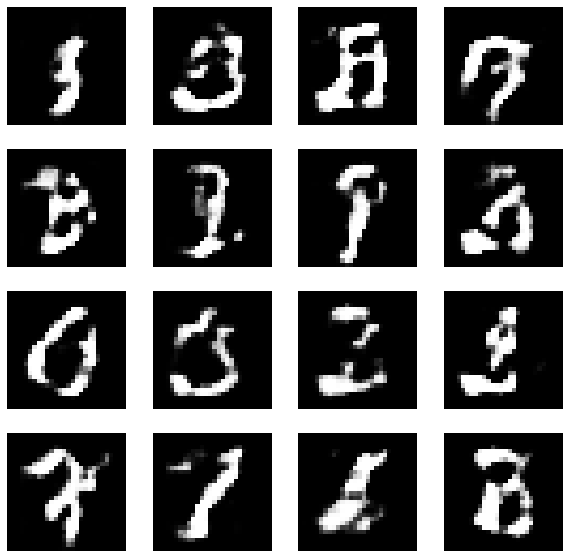

Época:  55


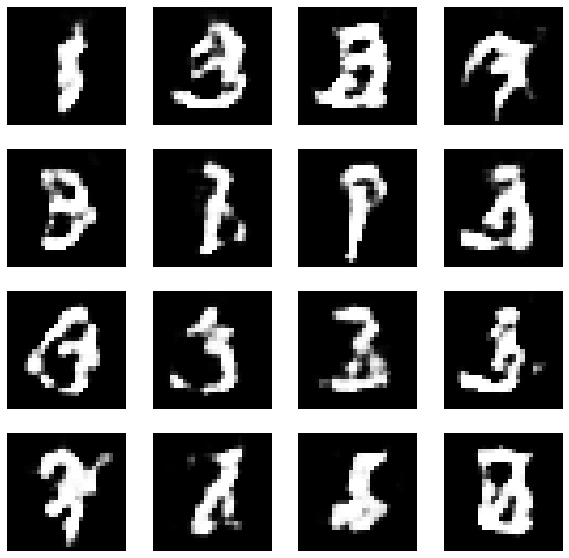

Época:  56


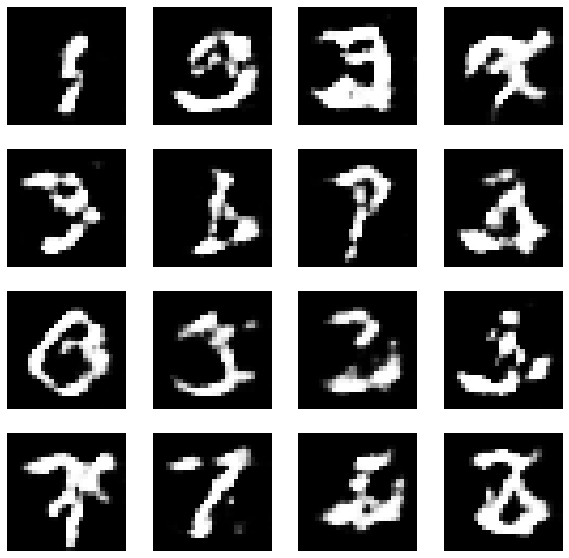

Época:  57


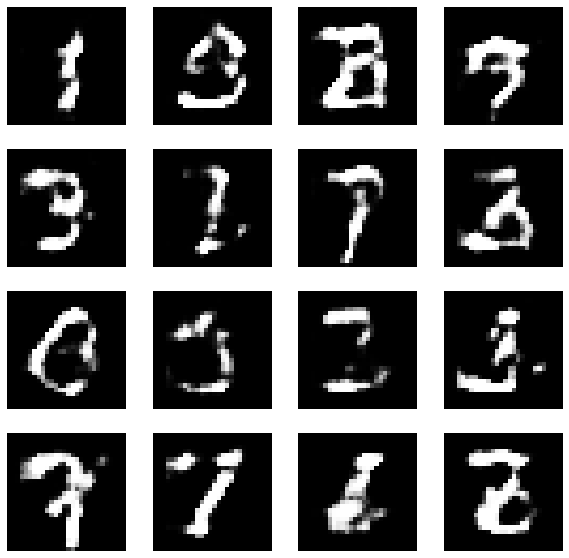

Época:  58


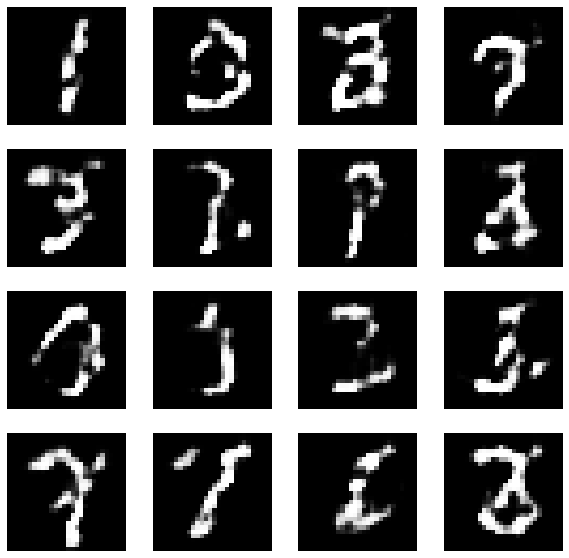

Época:  59


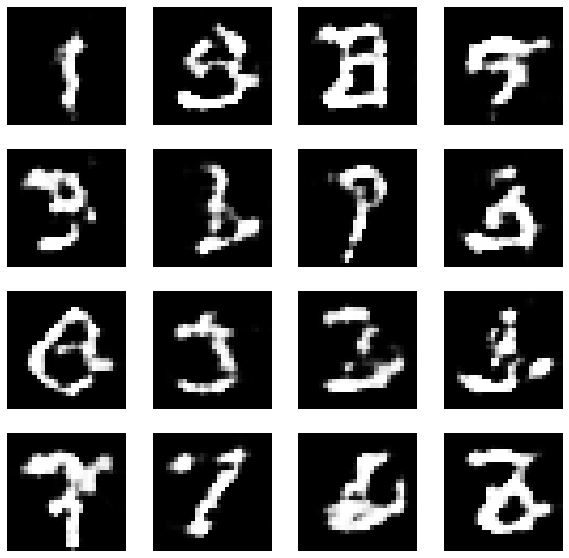

Época:  60


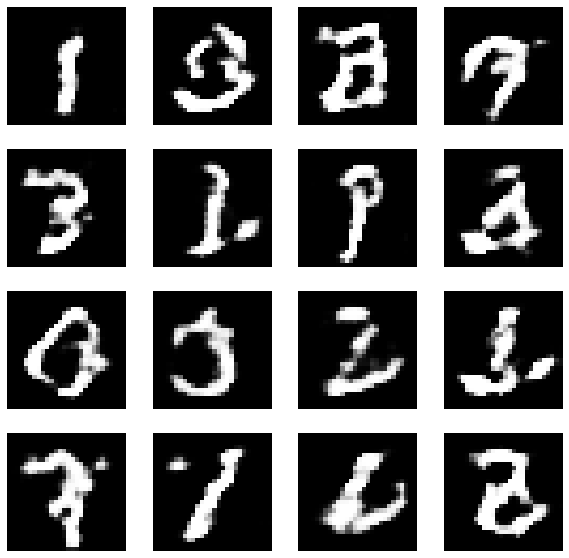

Época:  61


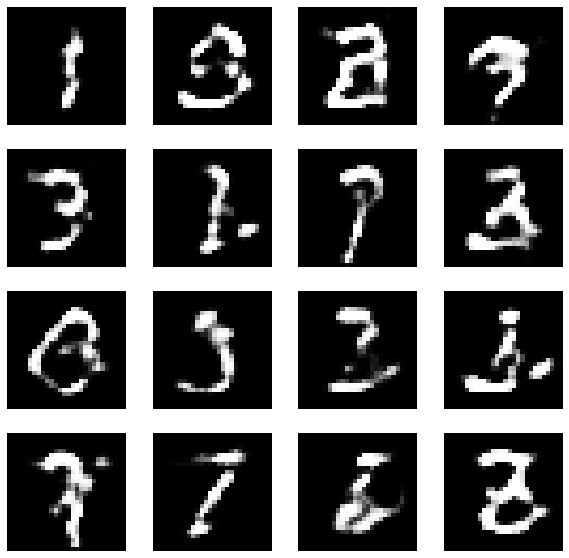

Época:  62


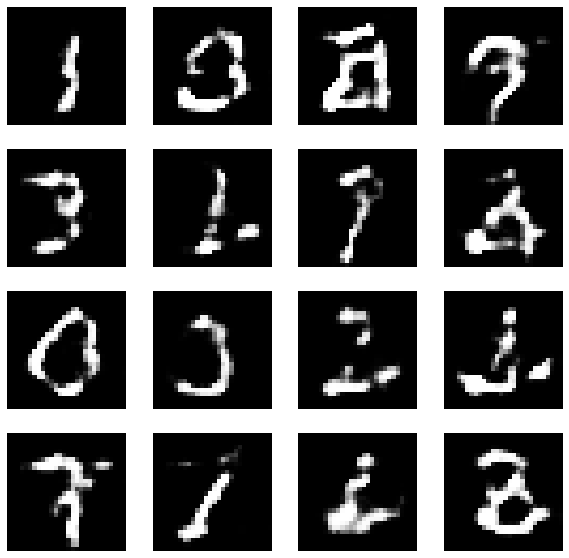

Época:  63


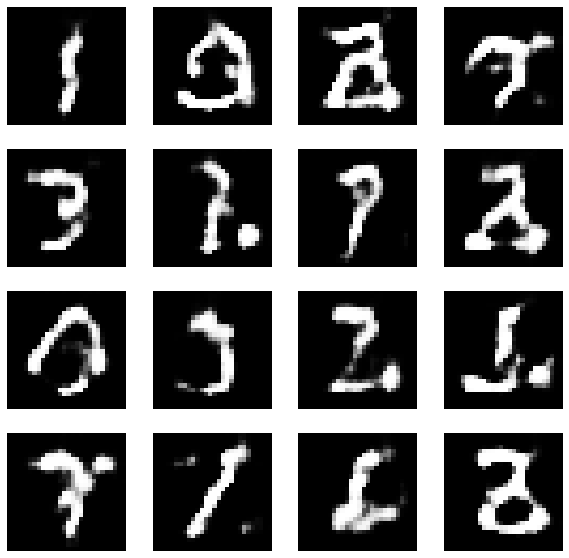

Época:  64


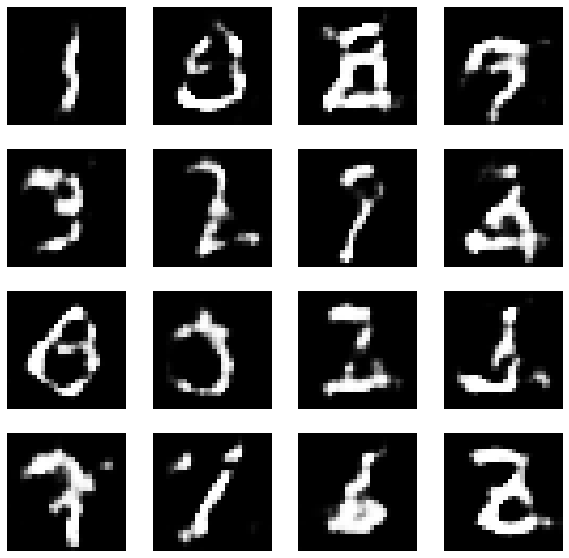

Época:  65


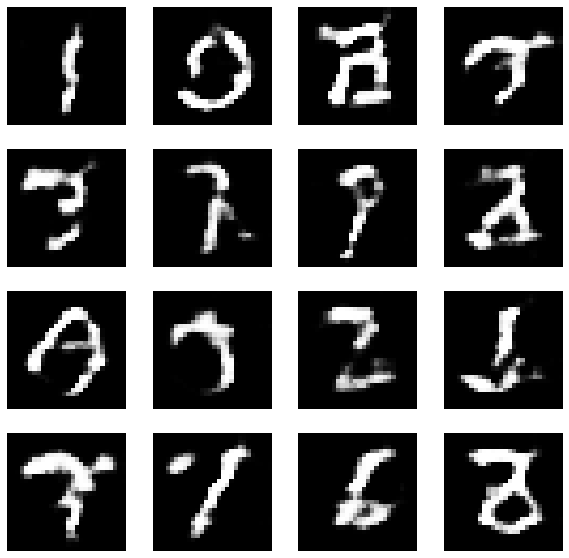

Época:  66


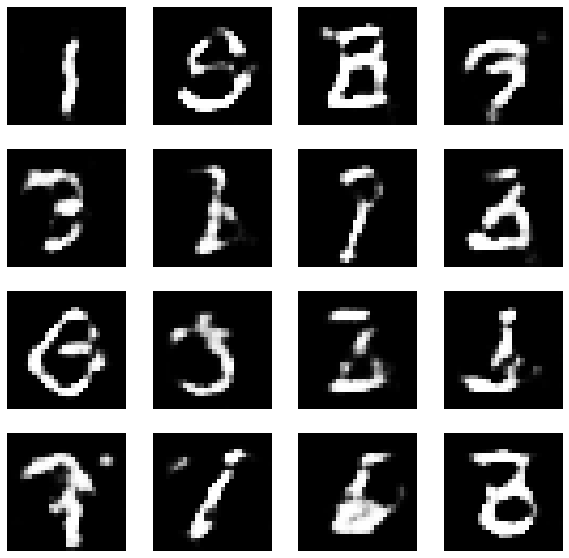

Época:  67


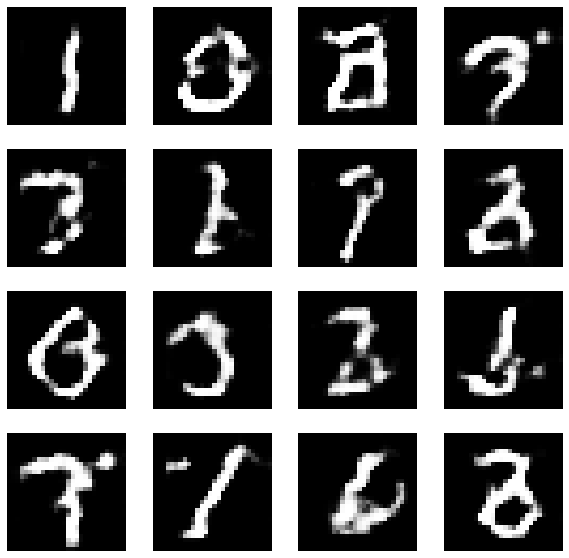

Época:  68


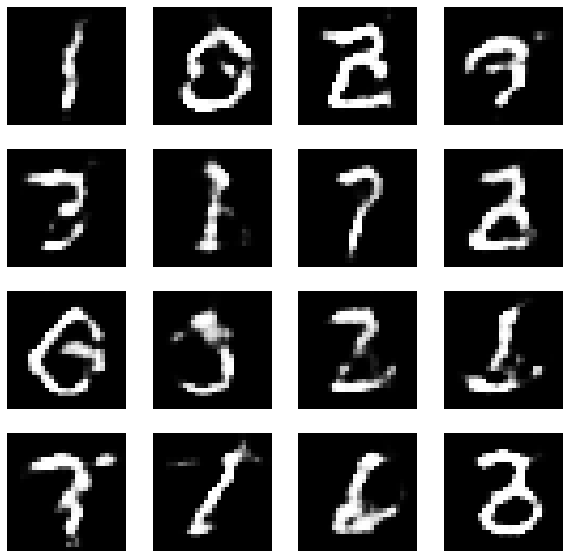

Época:  69


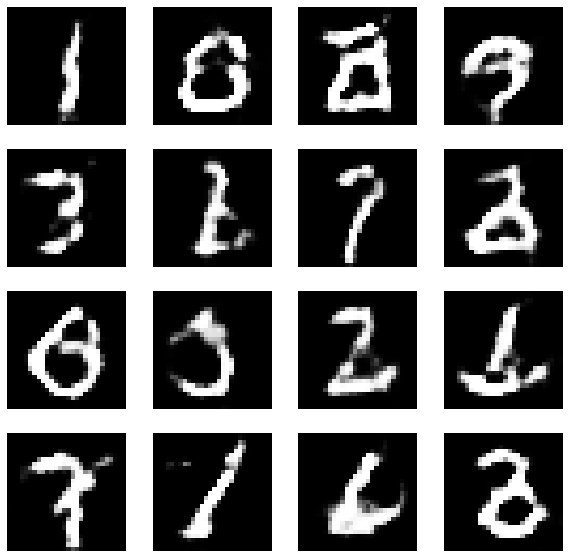

Época:  70


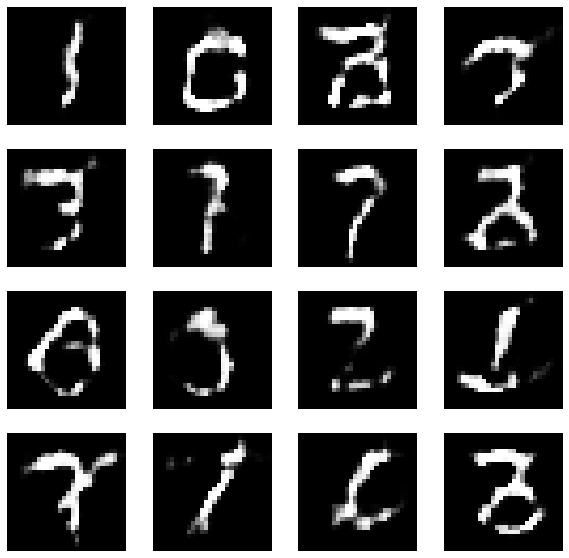

Época:  71


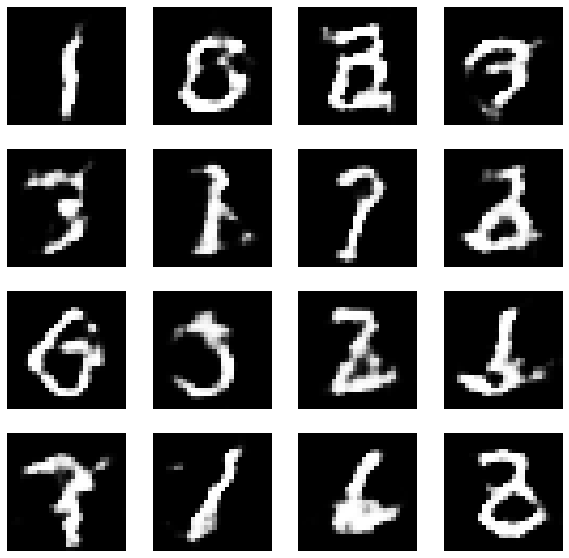

Época:  72


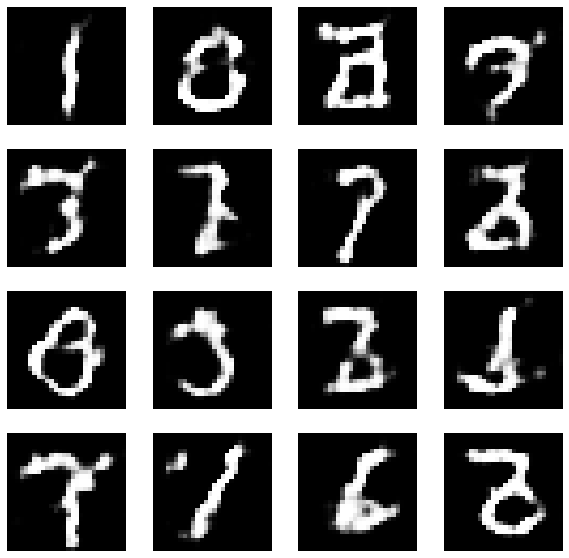

Época:  73


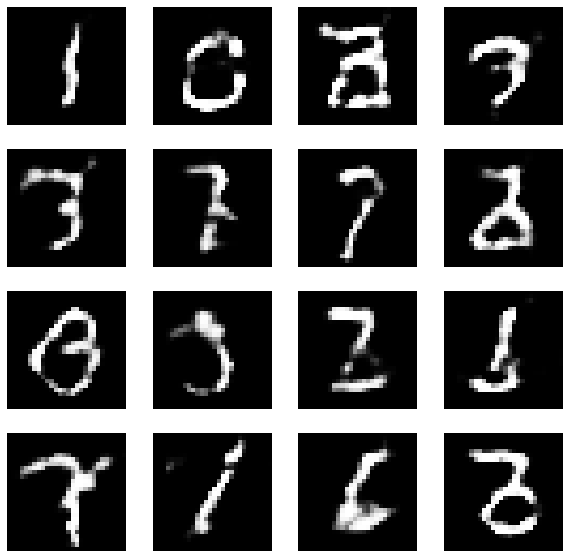

Época:  74


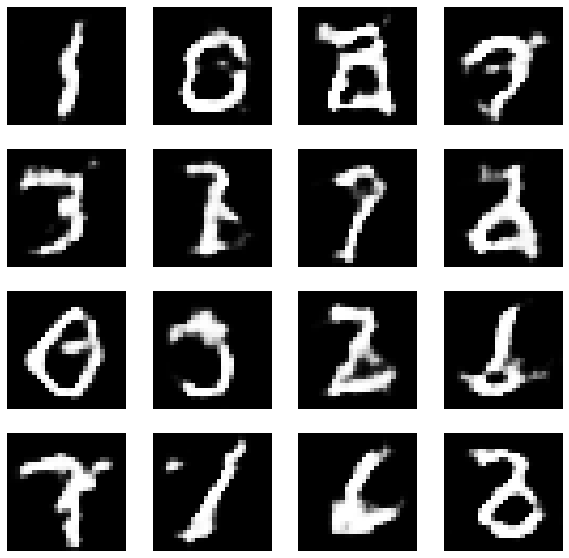

Época:  75


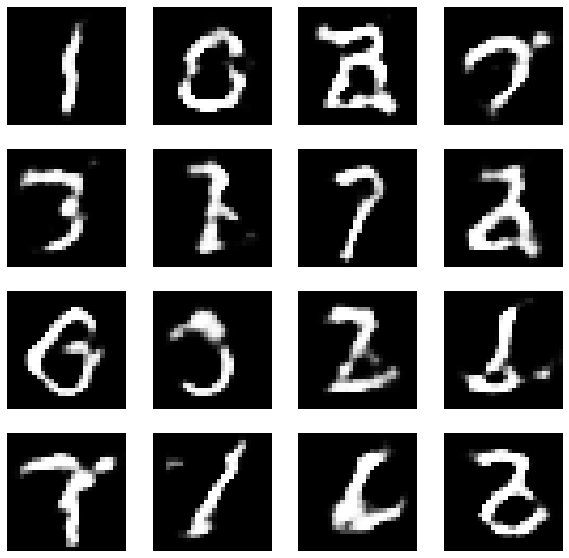

Época:  76


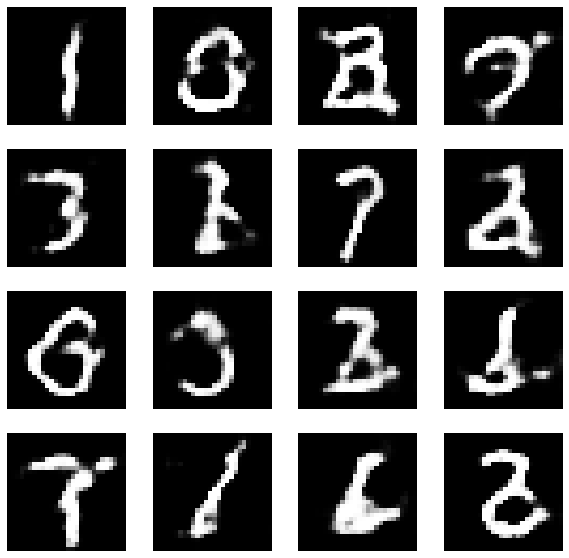

Época:  77


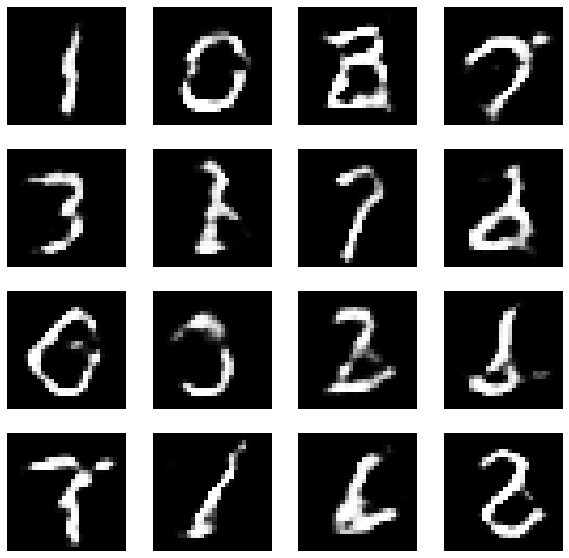

Época:  78


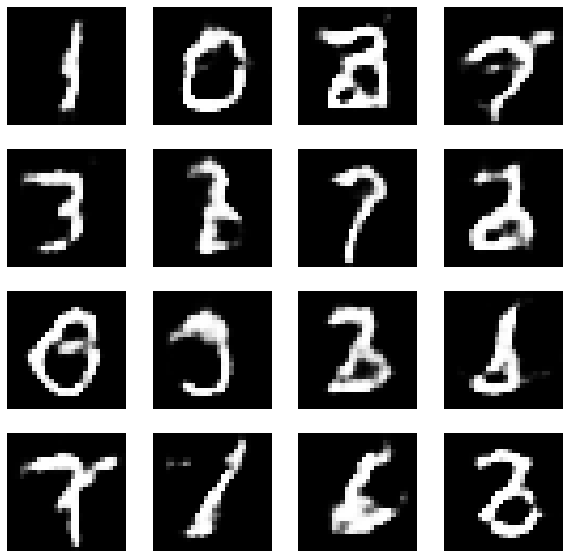

Época:  79


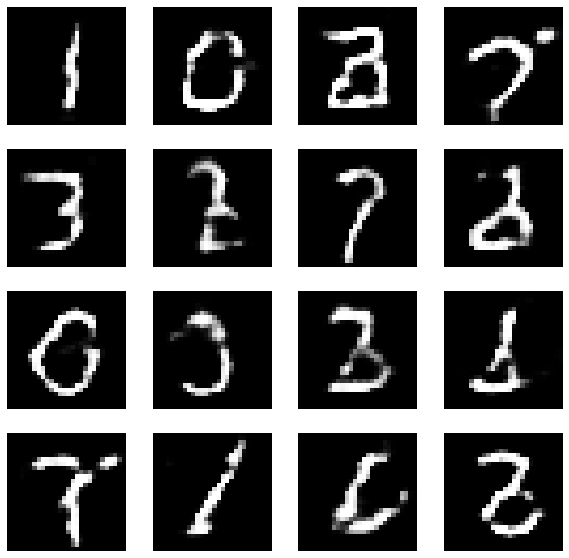

Época:  80


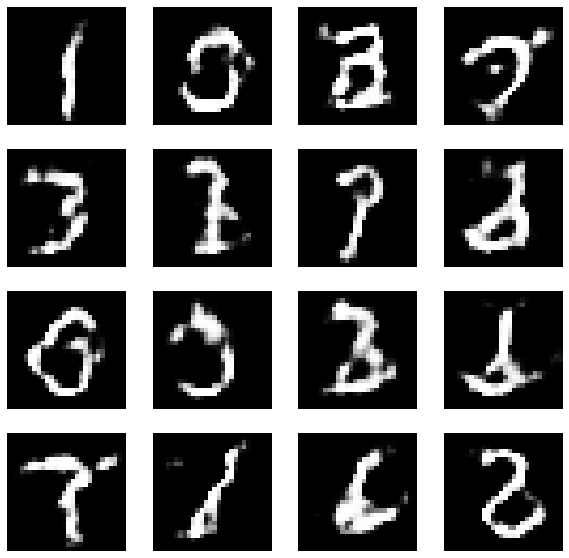

Época:  81


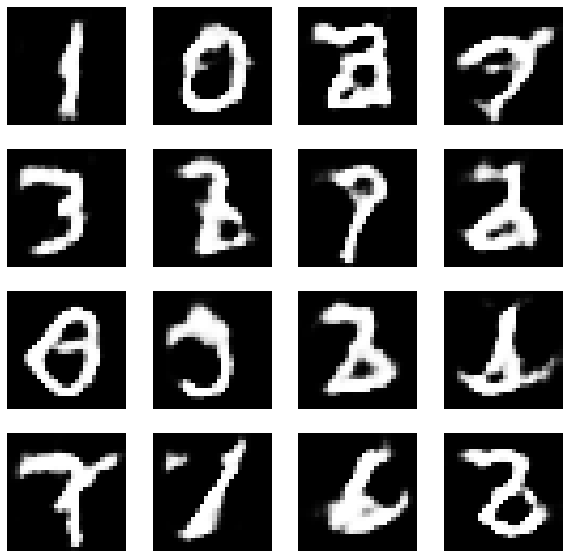

Época:  82


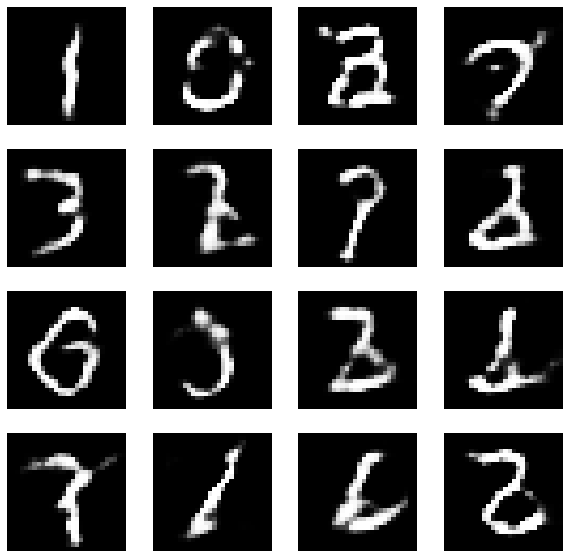

Época:  83


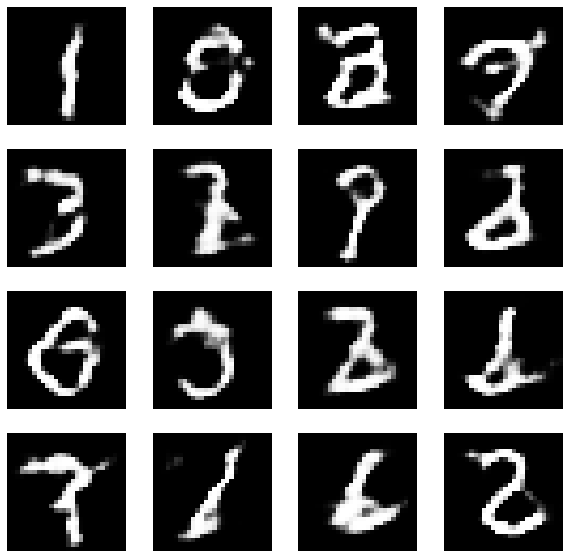

Época:  84


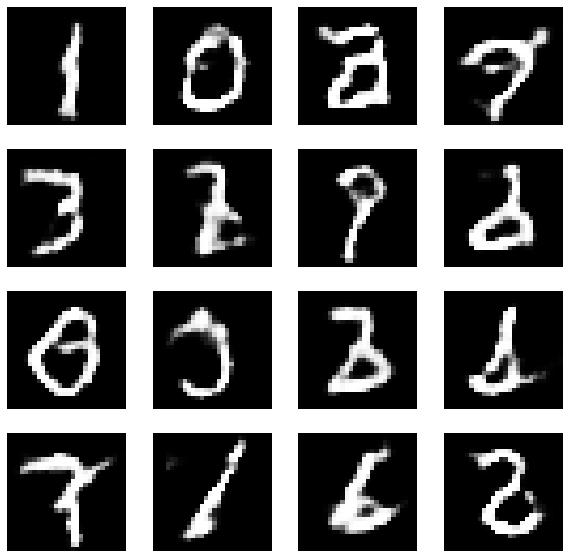

Época:  85


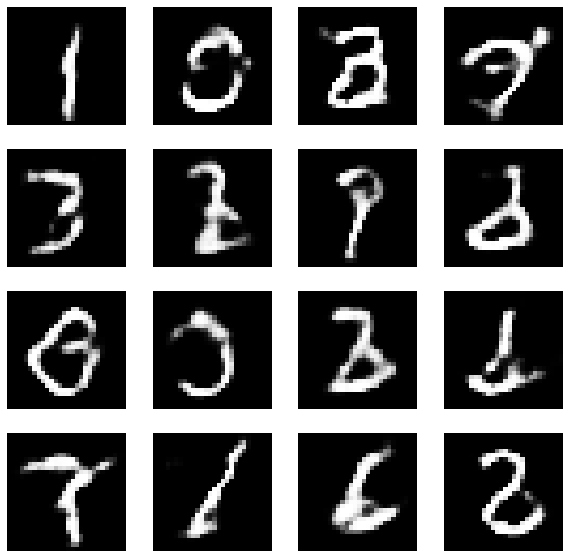

Época:  86


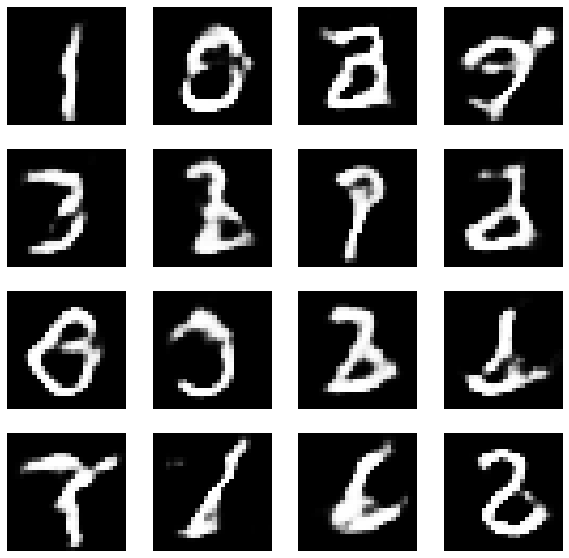

Época:  87


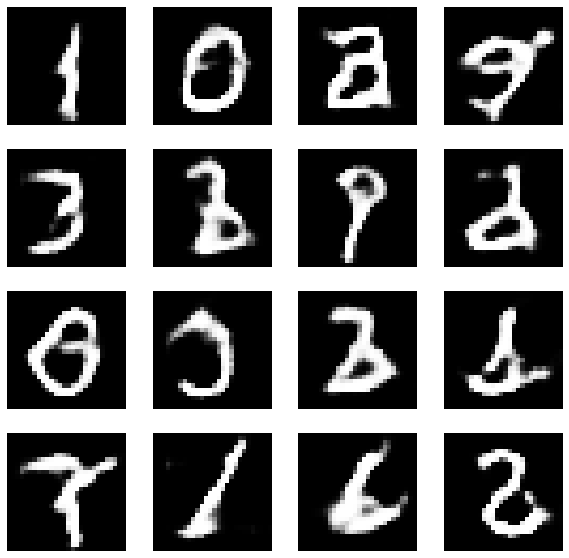

Época:  88


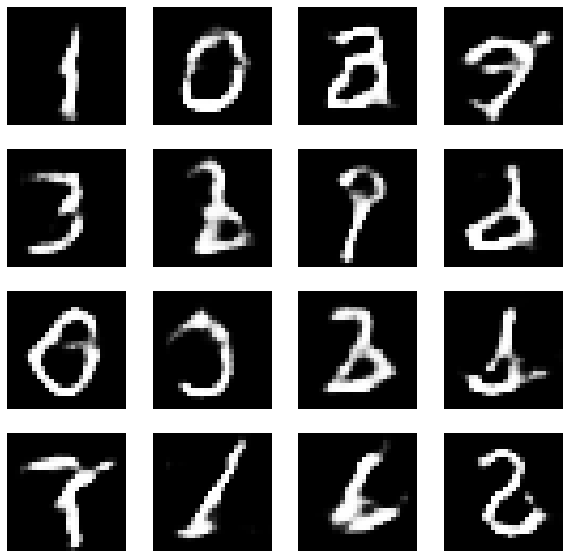

Época:  89


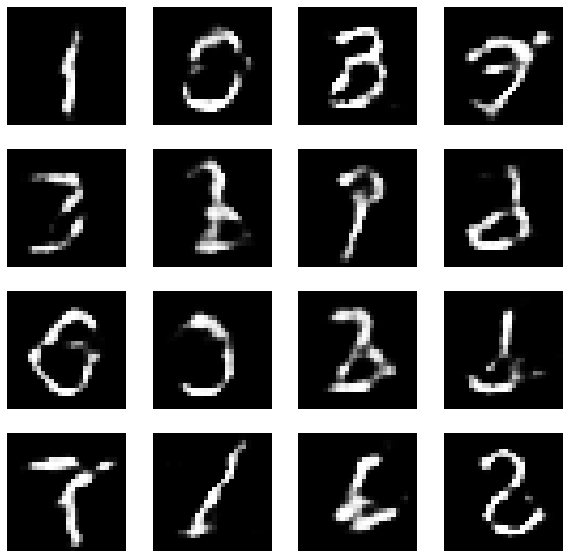

Época:  90


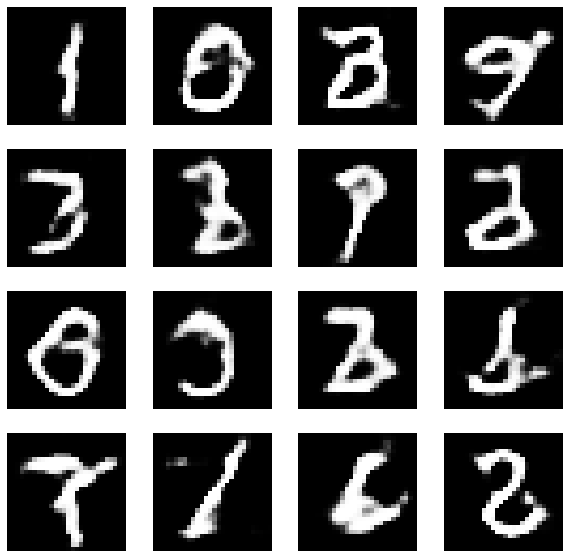

Época:  91


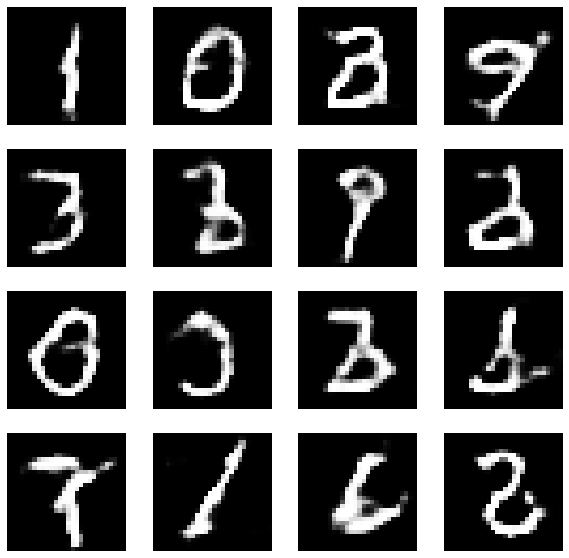

Época:  92


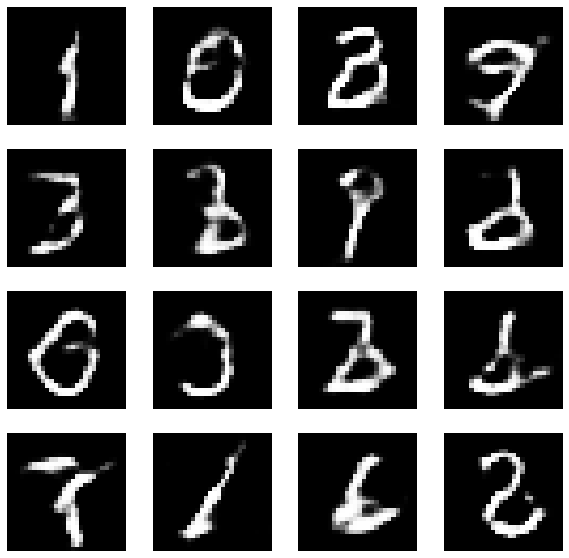

Época:  93


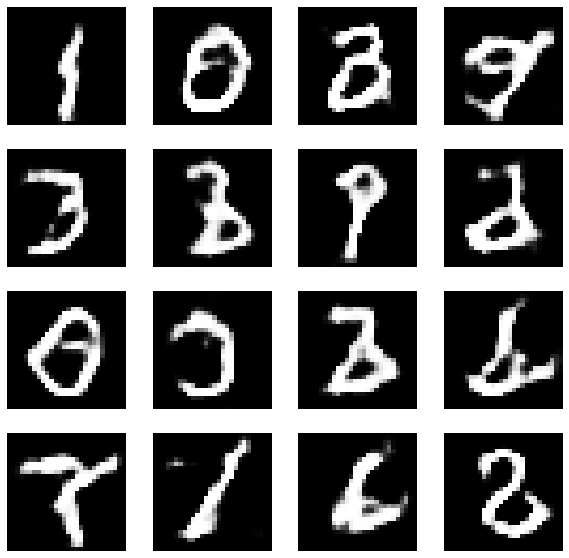

Época:  94


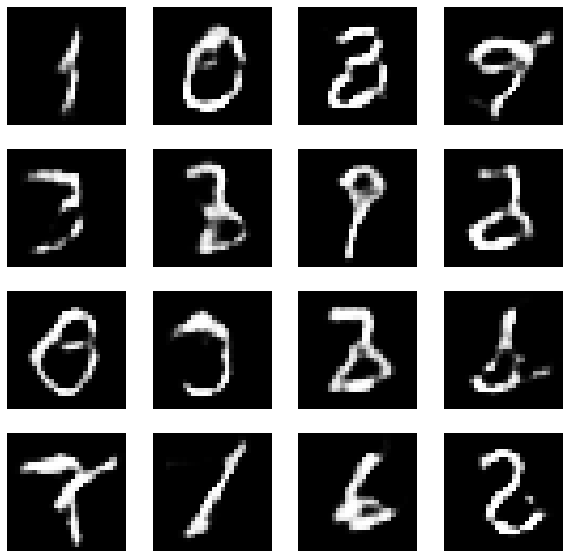

Época:  95


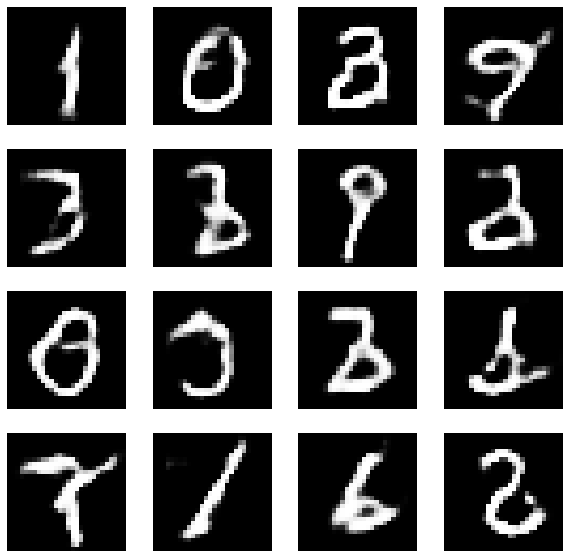

Época:  96


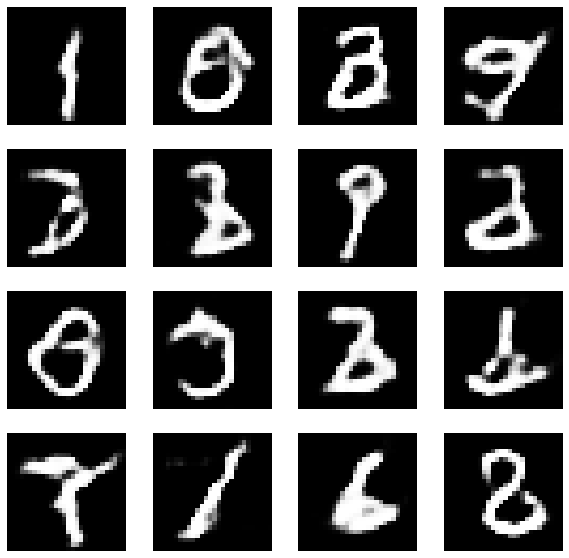

Época:  97


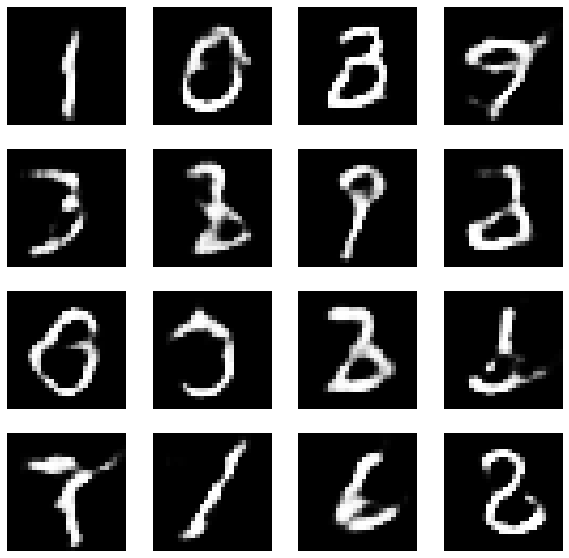

Época:  98


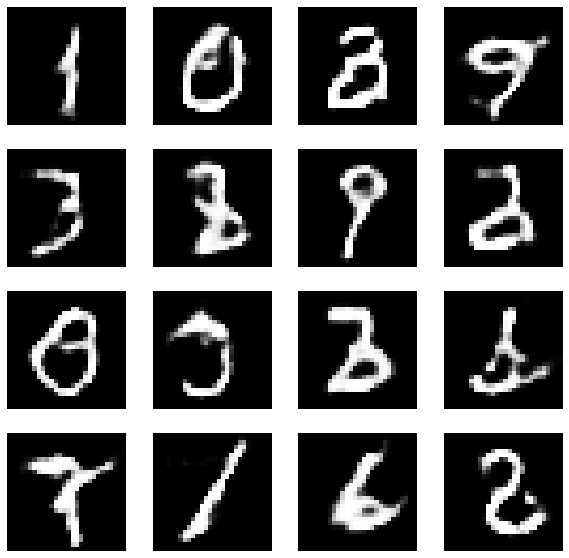

Época:  99


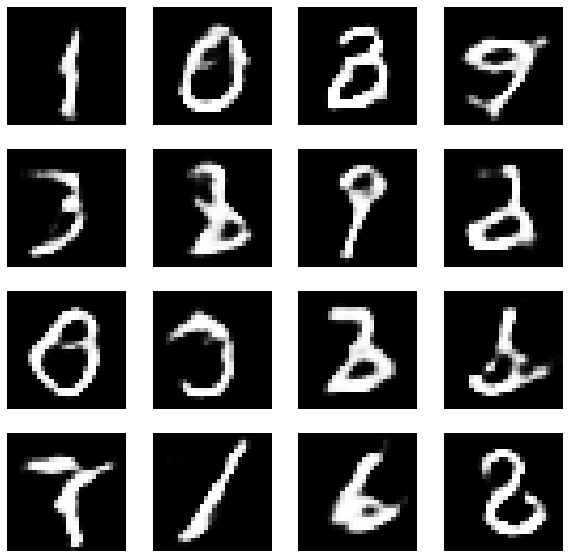

Época:  100


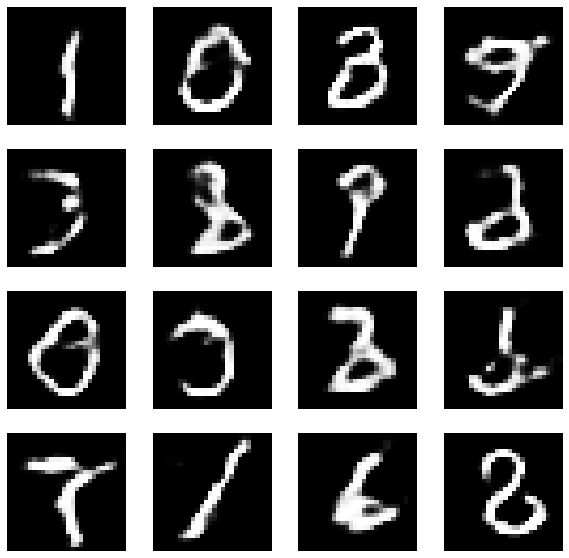

In [ ]:
treina_gan(X_treinamento, epocas, imagens_teste)